# Kerchunk and GRIB2:  A Case Study using NOAA's High-Resolution Rapid Refresh (HRRR) Dataset

<img src="../images/GRIB2.png" width=400 alt="HRRR GRIB2"></img>


## Overview
   
Within this notebook, we will cover:

1. Generating a list of GRIB2 files on a remote filesystem using `fsspec`
1. How to create reference files of GRIB2 files using ``Kerchunk`` 
1. Combining multiple `Kerchunk` reference files using `MultiZarrToZarr`
1. Reading the output with `Xarray` and `Intake`

This notebook shares many similarities with the [Multi-File Datasets with Kerchunk](../case_studies/kerchunk_multi_file.ipynb) and the [NetCDF/HDF5 National Water Model Case Study](../case_studies/NWM.ipynb), however this case studies examines another data format and uses `kerchunk.scan_grib` to create reference files. 


## Prerequisites
| Concepts | Importance | Notes |
| --- | --- | --- |
| [Kerchunk Basics](../foundations/kerchunk_basics) | Required | Core |
| [Multiple Files and Kerchunk](../foundations/kerchunk_multi_file) | Required | Core |
| [Introduction to Xarray](https://foundations.projectpythia.org/core/xarray/xarray-intro.html) | Required | IO/Visualization |
| [Intake Introduction](https://projectpythia.org/intake-cookbook/notebooks/intake_introduction.html) | Recommended | IO |
- **Time to learn**: 45 minutes
---

## Motivation

`Kerchunk` supports multiple input file formats. One of these is `GRIB2(GRIdded Information in Binary form)`, which is a binary file format primary used in meteorology and weather datasets. Similar to NetCDF/HDF5, GRIB2 does not support efficient, parallel access. Using `Kerchunk`, we can read this legacy format as if it were an ARCO (Analysis-Ready, Cloud-Optimized) data format such as Zarr. 

## About the Dataset

The `HRRR` is a NOAA real-time 3-km resolution, hourly updated, cloud-resolving, convection-allowing atmospheric model, initialized by 3km grids with 3km radar assimilation. Radar data is assimilated in the HRRR every 15 min over a 1-h period adding further detail to that provided by the hourly data assimilation from the 13km radar-enhanced Rapid Refresh.
NOAA releases a copy of this dataset via the AWS Registry of Open Data. 


## Imports

In [11]:
import datetime as dt
import glob

import fsspec
import ujson
import xarray as xr
from kerchunk.combine import MultiZarrToZarr
from kerchunk.grib2 import scan_grib
from tqdm import tqdm

## Create Input File List

Here we create `fsspec` files-systems for reading remote files and writing local reference files.
Next we are using `fsspec.glob` to retrieve a list of file paths and appending the `s3://` prefix to them.

In [12]:
# Initiate fsspec filesystems for reading and writing
fs_read = fsspec.filesystem("s3", anon=True, skip_instance_cache=True)
fs_write = fsspec.filesystem("")

# retrieve list of available days in archive
days_available = fs_read.glob("s3://noaa-hrrr-bdp-pds/hrrr.*")
# Read HRRR GRIB2 files from latest day
files = fs_read.glob(f"s3://{days_available[-1]}/conus/*wrfsfcf01.grib2")
# Append s3 prefix for filelist
files = sorted(["s3://" + f for f in files])

In [13]:
### OPTIONAL: To speed next section up, uncomment the next cell.  This will reduce the # of input files and speed up the example.

In [23]:
files = files[0:5]

In [24]:
files

['s3://noaa-hrrr-bdp-pds/hrrr.20230123/conus/hrrr.t00z.wrfsfcf01.grib2',
 's3://noaa-hrrr-bdp-pds/hrrr.20230123/conus/hrrr.t01z.wrfsfcf01.grib2',
 's3://noaa-hrrr-bdp-pds/hrrr.20230123/conus/hrrr.t02z.wrfsfcf01.grib2',
 's3://noaa-hrrr-bdp-pds/hrrr.20230123/conus/hrrr.t03z.wrfsfcf01.grib2',
 's3://noaa-hrrr-bdp-pds/hrrr.20230123/conus/hrrr.t04z.wrfsfcf01.grib2']

## Iterate through list of files and create `Kerchunk` indicies as `.json` reference files

In [16]:
# Note: scan_grib does not require a filter and will happily create a reference file for each available grib message. However when combining the grib messages using MultiZarrToZarr it is neccassary for the messages to share a coordinate system. Thus to make our lives easier and ensure all reference outputs from scan_grib share a coordinate system we pass a filter argument.
afilter = {"typeOfLevel": "heightAboveGround", "level": [2, 10]}
so = {"anon": True}
json_dir = "."


def make_json_name(
    file_url, message_number
):  # create a unique name for each reference file
    date = file_url.split("/")[3].split(".")[1]
    name = file_url.split("/")[5].split(".")[1:3]
    return f"{json_dir}{date}_{name[0]}_{name[1]}_message{message_number}.json"


def gen_json(file_url):

    out = scan_grib(
        file_url, storage_options=so, inline_threshold=100, filter=afilter
    )  # create the reference using scan_grib
    for i, message in enumerate(
        out
    ):  # scan_grib outputs a list containing one reference per grib message
        out_file_name = make_json_name(file_url, i)  # get name
        with fs_write.open(out_file_name, "w") as f:
            f.write(ujson.dumps(message))  # write to file

In [17]:
# Iterate through available input files and generate json reference files. Note: This could optionally be parallelized.
for f in tqdm(files):
    gen_json(f)

reference_jsons = sorted(fs_write.glob(json_dir + "*.json"))  # get list of file names

100%|██████████| 10/10 [43:32<00:00, 261.26s/it]


### Combine `Kerchunk` reference `.json` files

In [18]:
# Combine individual references into single consolidated reference
mzz = MultiZarrToZarr(
    reference_jsons,
    concat_dims=["valid_time"],
    identical_dims=["latitude", "longitude", "heightAboveGround", "step"],
)
multi_kerchunk = mzz.translate()

### Write combined `Kerchunk` reference file to `.json`

In [19]:
# Write Kerchunk .json record
output_fname = "HRRR_combined.json"
with open(f"{output_fname}", "wb") as f:
    f.write(ujson.dumps(multi_kerchunk).encode())

## Load Kerchunked dataset

In [20]:
# open dataset as zarr object using fsspec reference file system and Xarray
fs = fsspec.filesystem(
    "reference", fo=multi_kerchunk, remote_protocol="s3", remote_options={"anon": True}
)
m = fs.get_mapper("")
ds = xr.open_dataset(
    m, engine="zarr", backend_kwargs=dict(consolidated=False), chunks={"valid_time": 1}
)

## Plot a slice of the dataset

Here we are using `Xarray` to select a single time slice of the dataset and plot a temperature map of CONUS.

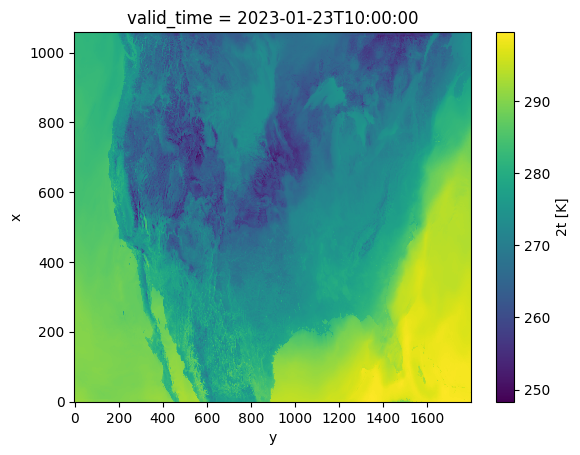

In [21]:
ds["2t"][-1].plot()

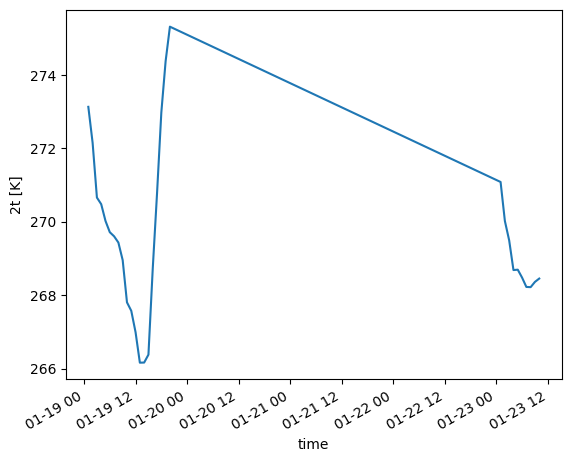

In [22]:
ds["2t"][:, 500, 500].plot()